In [1]:
import pickle
import time
import random
import math
from statistics import mean
from IPython.display import clear_output # clear_output(wait=True)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import f1_score, accuracy_score
from ast import literal_eval

In [3]:
sleep_minutes = 0

for i in range(sleep_minutes):
    clear_output(wait=True)
    print(f'{sleep_minutes-i}min left')
    time.sleep(60)

clear_output(wait=True)
print(f'done')

done


### Setting seed value

In [13]:
seed_value = 1234

tf.random.set_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

### Prepare data

In [ ]:
'''
num_words = 2000

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=num_words,
                                                                        seed=seed_value)

x_arr = np.concatenate((x_train, x_test))
y_arr = np.concatenate((y_train, y_test))

dataset_df = pd.DataFrame(columns=['x', 'y'])
dataset_df['x'] = x_arr
dataset_df['y'] = y_arr

dataset_df['y'].value_counts()
'''

In [23]:
def load_data(num_words=2000, seed_value=seed_value):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.reuters.load_data(path="reuters.npz",
                                                                               num_words=num_words,
                                                                               test_split=0.2,
                                                                               seed=seed_value)
    
    return (x_train, y_train), (x_test, y_test)


def prepare_data(x_train, y_train, 
                 x_test, y_test, 
                 num_classes=10, 
                 verbose=True):
    x_arr = np.concatenate((x_train, x_test))
    y_arr = np.concatenate((y_train, y_test))

    dataset_df = pd.DataFrame(columns=['x', 'y'])
    dataset_df['x'] = x_arr
    dataset_df['y'] = y_arr

    most_frequent_classes = dataset_df['y'].value_counts()[:num_classes].index.tolist()

    dataset_df = dataset_df[dataset_df['y'].isin(most_frequent_classes)].reset_index(drop=True)
    map_dict = dict(zip(most_frequent_classes, list(range(num_classes))))
    dataset_df['y'] = dataset_df['y'].map(map_dict)

    if verbose:
        print(f'Dataset: {dataset_df.shape}')
        print(f'Max lenght of x: {max(len(x_item) for x_item in x_arr)}')
        print('CLS   CNT')
        print(dataset_df['y'].value_counts())

    split_on_index = int(0.8*len(dataset_df))

    train_df = dataset_df.iloc[:split_on_index]
    test_df = dataset_df.iloc[split_on_index:]

    if verbose:
        print(f'Train: {train_df.shape}')
        print(f'Test: {test_df.shape}')

    x_train, y_train = np.array(train_df['x']), np.array(train_df['y'])
    x_test, y_test = np.array(test_df['x']), np.array(test_df['y'])

    return x_train, y_train, x_test, y_test

In [24]:
(x_train, y_train), (x_test, y_test) = load_data(num_words=2000, 
                                                 seed_value=seed_value)

x_train, y_train, x_test, y_test = prepare_data(x_train, y_train, 
                                                x_test, y_test, 
                                                num_classes=10, 
                                                verbose=True)

Dataset: (9509, 2)
Max lenght of x: 2376
CLS   CNT
0    3972
1    2423
2     682
3     543
4     537
5     473
6     339
7     209
8     177
9     154
Name: y, dtype: int64
Train: (7607, 2)
Test: (1902, 2)


### Models

In [25]:
class LSTMModel(tf.keras.Model):
    def __init__(self, num_words=2000, embedding_output=100, h_size=10, 
                 initializer='truncated_normal', max_length=2376):
        super(LSTMModel, self).__init__()

        self.num_words = num_words
        self.embedding_output = embedding_output
        self.h_size = h_size
        self.initializer = initializer
        self.max_length = max_length
        
        #self.embedding_layer = tf.keras.layers.Embedding(self.num_words, self.embedding_output)
        self.embedding_layer = tf.Variable(tf.random.uniform([self.num_words, self.embedding_output]))

        self.weights_f = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_output), 
                                         initializer=self.initializer,
                                         trainable=True)
        self.bias_f = self.add_weight(shape=(self.h_size, 1), 
                                      initializer=self.initializer, 
                                      trainable=True)
        
        self.weights_i = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_output), 
                                         initializer=self.initializer,
                                         trainable=True)
        self.bias_i = self.add_weight(shape=(self.h_size, 1), 
                                      initializer=self.initializer, 
                                      trainable=True)
        
        self.weights_c = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_output), 
                                         initializer=self.initializer,
                                         trainable=True)
        self.bias_c = self.add_weight(shape=(self.h_size, 1), 
                                      initializer=self.initializer, 
                                      trainable=True)
        
        self.weights_o = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_output), 
                                         initializer=self.initializer,
                                         trainable=True)
        self.bias_o = self.add_weight(shape=(self.h_size, 1), 
                                      initializer=self.initializer, 
                                      trainable=True)

        self.last_layer = tf.keras.layers.Dense(units=10, activation='softmax')
    

    def lstm_cell(self, x_t, c_prev, h_prev):
        x_t = tf.transpose(x_t)

        f = tf.sigmoid(tf.matmul(self.weights_f, tf.concat([x_t, h_prev], 0)) + self.bias_f)
        i = tf.sigmoid(tf.matmul(self.weights_i, tf.concat([x_t, h_prev], 0)) + self.bias_i)
        o = tf.sigmoid(tf.matmul(self.weights_o, tf.concat([x_t, h_prev], 0)) + self.bias_o)
        c = f * c_prev + i * tf.tanh(tf.matmul(self.weights_c, tf.concat([x_t, h_prev], 0)) + self.bias_c)        
        h = o * tf.tanh(c)
        
        return c, h
    

    def call(self, inputs, training=False):
        #x = self.embedding_layer(inputs)
        x = tf.nn.embedding_lookup(self.embedding_layer, inputs)

        c = tf.zeros(shape=(self.h_size, len(x)))
        h = tf.zeros(shape=(self.h_size, len(x)))

        for i in range(x.shape[1]):
            c, h = self.lstm_cell(x[:, i], c, h)

        out = self.last_layer(tf.transpose(h))
        
        return out
    

    def dataset_to_batches(self, x, y=None, batch_size=100):
        #print(x.shape)
        x = tf.keras.preprocessing.sequence.pad_sequences(sequences=x, 
                                                          padding='post', 
                                                          maxlen=self.max_length)
        #print(x.shape)
        if y is not None: # TRAIN DATASET
            y = tf.dtypes.cast(y, tf.float32)
            ds = tf.data.Dataset.from_tensor_slices((x, y))
            ds = ds.shuffle(buffer_size=len(x)).batch(batch_size=batch_size)
        else: # TEST DATASET
            ds = tf.data.Dataset.from_tensor_slices(x)
            ds = ds.batch(batch_size=batch_size)

        return ds
    

    def fit(self, **kwargs):
        train_x = kwargs.get("train_x", x_train)
        train_y = kwargs.get("train_y", y_train)
        test_x = kwargs.get("test_x", x_train)
        test_y = kwargs.get("test_y", y_train)
        batch_size = kwargs.get("batch_size", 100)
        train_ds = self.dataset_to_batches(x=train_x, y=train_y, batch_size=batch_size)
        test_ds = self.dataset_to_batches(x=test_x, y=test_y, batch_size=batch_size)
        
        learning_rate = kwargs.get("learning_rate", 0.001)
        optimizer = kwargs.get("optimizer", tf.keras.optimizers.Adam)
        optimizer = optimizer(learning_rate=learning_rate)

        epochs = kwargs.get("epochs", 10)
        cost_func = kwargs.get('cost_func', tf.keras.losses.SparseCategoricalCrossentropy())

        self.loss_list = []
        self.acc_list = []
        self.f1_list = []
        self.time_list = []
        
        self.test_loss_list = []
        self.test_acc_list = []
        self.test_f1_list = []
        
        loss_metric = tf.keras.metrics.Mean(name='loss_metric')
        acc_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='acc_metric')
        f1_metric = tfa.metrics.F1Score(num_classes=10, average="macro")

        for epoch in range(epochs):
            timer_start = time.time()
            for x, y in train_ds:
                with tf.GradientTape() as tape:
                    logits = self.call(x, training=True)
                    loss = cost_func(y, logits)
                grads = tape.gradient(loss, self.trainable_weights)
                optimizer.apply_gradients(zip(grads, self.trainable_weights))
                loss_metric(loss)
                acc_metric(y, logits)
                f1_metric.update_state(tf.squeeze(tf.one_hot(tf.dtypes.cast(y, tf.int32), depth=10)), 
                                       tf.one_hot(tf.argmax(logits, axis=-1), depth=10))
                
            exec_time = time.time() - timer_start
            self.loss_list.append(float(loss_metric.result()))
            self.acc_list.append(acc_metric.result())
            self.f1_list.append(f1_metric.result())
            self.time_list.append(exec_time)

            loss_metric.reset_states()
            acc_metric.reset_states()
            f1_metric.reset_states()
            
            print('TRAINING: Epoch: %d  -  loss: %.3f; accuracy: %.3f; f1: : %.3f; time: %.3fs'%(epoch, 
                                                                                                 self.loss_list[-1], 
                                                                                                 self.acc_list[-1], 
                                                                                                 self.f1_list[-1], 
                                                                                                 self.time_list[-1]))
            
            for x, y in test_ds:
                logits = self.call(x, training=False)
                loss = cost_func(y, logits)
                
                loss_metric(loss)
                acc_metric(y, logits)
                f1_metric.update_state(tf.squeeze(tf.one_hot(tf.dtypes.cast(y, tf.int32), depth=10)), 
                                       tf.one_hot(tf.argmax(logits, axis=-1), depth=10))

            self.test_loss_list.append(float(loss_metric.result()))
            self.test_acc_list.append(acc_metric.result())
            self.test_f1_list.append(f1_metric.result())

            loss_metric.reset_states()
            acc_metric.reset_states()
            f1_metric.reset_states()
            
            print('TEST: Epoch: %d  -  loss: %.3f; accuracy: %.3f; f1: : %.3f'%(epoch, 
                                                                                self.test_loss_list[-1], 
                                                                                self.test_acc_list[-1], 
                                                                                self.test_f1_list[-1]))
            

    def predict(self, x_test, batch_size):
        x_test = self.dataset_to_batches(x=x_test, batch_size=batch_size)

        y_pred = []
        for x in x_test:
            logits = self.call(x)
            y_pred.extend(tf.argmax(logits, axis=1, output_type=tf.int32))

        return y_pred

In [26]:
class RNNModel(LSTMModel):
    def __init__(self, num_words=2000, embedding_output=100, h_size=8, 
                 initializer='truncated_normal', max_length=2376):
        super(LSTMModel, self).__init__()

        self.num_words = num_words
        self.embedding_output = embedding_output
        self.h_size = h_size
        self.initializer = initializer
        self.max_length = max_length
        
        #self.embedding_layer = tf.keras.layers.Embedding(self.num_words, self.embedding_output)
        self.embedding_layer = tf.Variable(tf.random.uniform([self.num_words, self.embedding_output]))
        
        self.weights_o = self.add_weight(shape=(self.h_size, self.h_size + self.embedding_output), 
                                         initializer=self.initializer,
                                         trainable=True)
        self.bias_o = self.add_weight(shape=(self.h_size, 1), 
                                      initializer=self.initializer, 
                                      trainable=True)

        self.last_layer = tf.keras.layers.Dense(units=10, activation='softmax')
    

    def rnn_cell(self, x_t, h_prev):
        x_t = tf.transpose(x_t)

        h = tf.tanh(tf.matmul(self.weights_o, tf.concat([x_t, h_prev], 0)) + self.bias_o)
        
        return h
    

    def call(self, inputs, training=False):
        #x = self.embedding_layer(inputs)
        x = tf.nn.embedding_lookup(self.embedding_layer, inputs)

        h = tf.zeros(shape=(self.h_size, len(x)))

        for i in range(x.shape[1]):
            h = self.rnn_cell(x[:, i], h)

        out = self.last_layer(tf.transpose(h))
        
        return out

### Function to perform experiments

In [27]:
def model_experiment(x_train=x_train, y_train=y_train, 
                     x_test=x_test, y_test=y_test, 
                     model=RNNModel, 
                     batch_size=100, 
                     learning_rate=0.001, 
                     optimizer=tf.keras.optimizers.Adam, 
                     epochs=10, 
                     cost_func=tf.keras.losses.SparseCategoricalCrossentropy(), 
                     num_words=2000, embedding_output=250, 
                     h_size=10, initializer='truncated_normal', 
                     max_length=2376):
    tf.random.set_seed(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)

    model = model(num_words=num_words, embedding_output=embedding_output, 
                  h_size=h_size, initializer=initializer, 
                  max_length=max_length)
    
    model.fit(train_x=x_train, train_y=y_train, 
              test_x=x_test, test_y=y_test, 
              batch_size=batch_size, 
              learning_rate=learning_rate, 
              optimizer=optimizer, 
              epochs=epochs, 
              cost_func=cost_func)

    y_pred = model.predict(x_test, batch_size)
    f1 = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    
    return model, f1, acc

#### Testing the settings of the following parameters:
* max_length
* h_size
* embedding_output
* epochs
* model

In [79]:
result_df = pd.DataFrame(columns=['max_length', 'h_size', 'embedding_output', 'epochs', 'model', 
                                  'f1_score', 'accuracy', 'loss', 'time_per_epoch', 'time'])

In [ ]:
settings_max_length = [64, 128]
#settings_max_length = [64]
settings_h_size = [10, 30]
#settings_h_size = [10]
settings_embedding_output = [250, 500]
#settings_embedding_output = [500]
settings_epochs = [5, 10, 20]
#settings_epochs = [5]
settings_model = [RNNModel, LSTMModel]
#settings_model = [LSTMModel]

batch_size = 100
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()

num_words = 2000
initializer='truncated_normal'

for max_length in settings_max_length:
    for h_size in settings_h_size:
        for embedding_output in settings_embedding_output:
            for epochs in settings_epochs:
                for model in settings_model:
                    model, f1, acc = model_experiment(x_train=x_train, y_train=y_train, 
                                                      x_test=x_test, y_test=y_test, 
                                                      model=model, 
                                                      batch_size=batch_size, 
                                                      learning_rate=learning_rate, 
                                                      optimizer=optimizer, 
                                                      epochs=epochs, 
                                                      cost_func=cost_func, 
                                                      num_words=num_words, embedding_output=embedding_output, 
                                                      h_size=h_size, initializer=initializer, 
                                                      max_length=max_length)

                    result_df = result_df.append({'max_length': max_length, 
                                                  'h_size': h_size, 
                                                  'embedding_output': embedding_output, 
                                                  'epochs': epochs, 
                                                  'model': model.__class__.__name__, 
                                                  'f1_score': f1, 
                                                  'accuracy': acc, 
                                                  'loss': model.loss_list[-1], 
                                                  'time_per_epoch': np.mean(model.time_list), 
                                                  'time': np.sum(model.time_list)}, ignore_index=True)

                    print(f1)

In [81]:
result_df

,max_length,h_size,embedding_output,epochs,model,f1_score,accuracy,loss,time_per_epoch,time
0,64,10,250,5,RNNModel,0.130915,0.458465,1.382289,7.286460,36.432300
1,64,10,250,5,LSTMModel,0.208922,0.605152,1.009105,18.086934,90.434670
2,64,10,250,10,RNNModel,0.152945,0.487382,1.327571,7.252348,72.523485
3,64,10,250,10,LSTMModel,0.314641,0.687697,0.815740,18.001405,180.014052
4,64,10,250,20,RNNModel,0.160477,0.517876,1.227459,7.300419,146.008381
5,64,10,250,20,LSTMModel,0.464805,0.734490,0.478595,18.238959,364.779174
6,64,10,500,5,RNNModel,0.132597,0.479495,1.377176,8.124193,40.620965
7,64,10,500,5,LSTMModel,0.329325,0.697161,0.875908,19.293135,96.465674
8,64,10,500,10,RNNModel,0.147611,0.423239,1.348626,8.313342,83.133417
9,64,10,500,10,LSTMModel,0.461710,0.728181,0.532646,19.027054,190.270542


In [82]:
result_df.to_csv('results_1.csv')

#### Testing the settings of the following parameters:
* num_words

In [32]:
result_df = pd.DataFrame(columns=['num_words', 
                                  'f1_score', 'accuracy', 'loss', 'time_per_epoch', 'time'])

In [ ]:
model = LSTMModel

batch_size = 100
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam
epochs = 20
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()

settings_num_words = [250, 500, 1000, 2000]
embedding_output = 500
h_size = 10
initializer='truncated_normal'
max_length = 64

for num_words in settings_num_words:
    (x_train, y_train), (x_test, y_test) = load_data(num_words=num_words, 
                                                     seed_value=seed_value)

    x_train, y_train, x_test, y_test = prepare_data(x_train, y_train, 
                                                    x_test, y_test, 
                                                    num_classes=10, 
                                                    verbose=False)
    
    model = LSTMModel
    model, f1, acc = model_experiment(x_train=x_train, y_train=y_train, 
                                      x_test=x_test, y_test=y_test, 
                                      model=model, 
                                      batch_size=batch_size, 
                                      learning_rate=learning_rate, 
                                      optimizer=optimizer, 
                                      epochs=epochs, 
                                      cost_func=cost_func, 
                                      num_words=num_words, embedding_output=embedding_output, 
                                      h_size=h_size, initializer=initializer, 
                                      max_length=max_length)

    result_df = result_df.append({'num_words': num_words, 
                                  'f1_score': f1, 
                                  'accuracy': acc, 
                                  'loss': model.loss_list[-1], 
                                  'time_per_epoch': np.mean(model.time_list), 
                                  'time': np.sum(model.time_list)}, ignore_index=True)

    print(f1)

In [40]:
result_df

,num_words,f1_score,accuracy,loss,time_per_epoch,time
0,250.0,0.266924,0.695058,0.950942,16.691123,333.822459
1,500.0,0.525455,0.776551,0.643554,16.820410,336.408195
2,1000.0,0.511732,0.767613,0.564196,16.844416,336.888314
3,2000.0,0.539121,0.754469,0.449871,16.895705,337.914092


In [41]:
result_df.to_csv('results_2.csv')

### Best settings found

In [86]:
model = LSTMModel

batch_size = 100
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam
epochs = 20
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()

num_words=2000
embedding_output = 500
h_size = 10
initializer='truncated_normal'
max_length = 64

model, f1, acc = model_experiment(x_train=x_train, y_train=y_train, 
                                  x_test=x_test, y_test=y_test, 
                                  model=model, 
                                  batch_size=batch_size, 
                                  learning_rate=learning_rate, 
                                  optimizer=optimizer, 
                                  epochs=epochs, 
                                  cost_func=cost_func, 
                                  num_words=num_words, embedding_output=embedding_output, 
                                  h_size=h_size, initializer=initializer, 
                                  max_length=max_length)

TRAINING: Epoch: 0  -  loss: 1.665; accuracy: 0.484; f1: : 0.113; time: 25.822s
TEST: Epoch: 0  -  loss: 1.549; accuracy: 0.551; f1: : 0.128
TRAINING: Epoch: 1  -  loss: 1.409; accuracy: 0.582; f1: : 0.137; time: 25.639s
TEST: Epoch: 1  -  loss: 1.278; accuracy: 0.611; f1: : 0.145
TRAINING: Epoch: 2  -  loss: 1.312; accuracy: 0.612; f1: : 0.145; time: 25.688s
TEST: Epoch: 2  -  loss: 1.243; accuracy: 0.604; f1: : 0.140
TRAINING: Epoch: 3  -  loss: 1.233; accuracy: 0.618; f1: : 0.147; time: 25.705s
TEST: Epoch: 3  -  loss: 1.295; accuracy: 0.610; f1: : 0.147
TRAINING: Epoch: 4  -  loss: 1.152; accuracy: 0.639; f1: : 0.189; time: 25.861s
TEST: Epoch: 4  -  loss: 1.094; accuracy: 0.654; f1: : 0.215
TRAINING: Epoch: 5  -  loss: 1.029; accuracy: 0.694; f1: : 0.259; time: 25.693s
TEST: Epoch: 5  -  loss: 0.997; accuracy: 0.721; f1: : 0.287
TRAINING: Epoch: 6  -  loss: 0.913; accuracy: 0.730; f1: : 0.292; time: 25.758s
TEST: Epoch: 6  -  loss: 0.951; accuracy: 0.702; f1: : 0.275
TRAINING: Epo

In [87]:
f1

0.5472713700800769

In [89]:
def plot_results(list_to_plot, title, xlab, ylab):
    #arr = np.asarray(list_to_plot)
    #arr = np.mean(arr.reshape(-1, el_per_batch), axis=1) el_per_batch = math.ceil(len(train_X) / batch_size)
    plt.plot(list_to_plot)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)

### Train

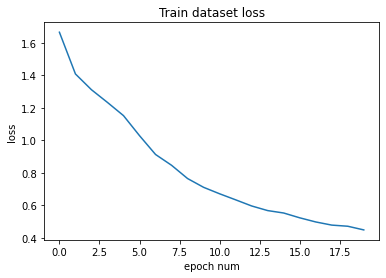

In [90]:
plot_results(list_to_plot=model.loss_list, 
             title='Train dataset loss', 
             xlab='epoch num', 
             ylab='loss')

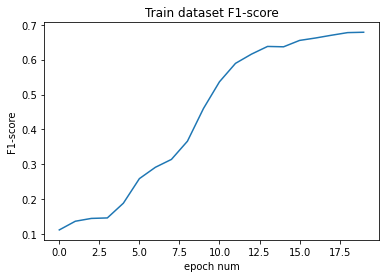

In [91]:
plot_results(list_to_plot=model.f1_list, 
             title='Train dataset F1-score', 
             xlab='epoch num', 
             ylab='F1-score')

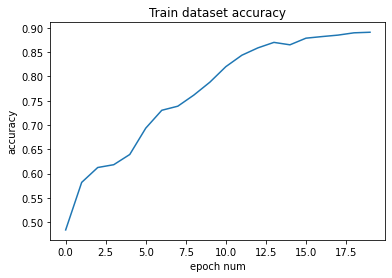

In [92]:
plot_results(list_to_plot=model.acc_list, 
             title='Train dataset accuracy', 
             xlab='epoch num', 
             ylab='accuracy')

### Test

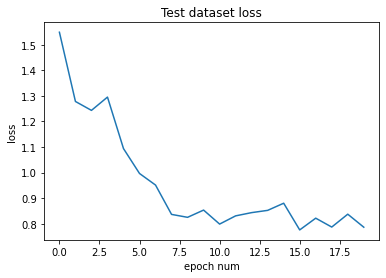

In [93]:
plot_results(list_to_plot=model.test_loss_list, 
             title='Test dataset loss', 
             xlab='epoch num', 
             ylab='loss')

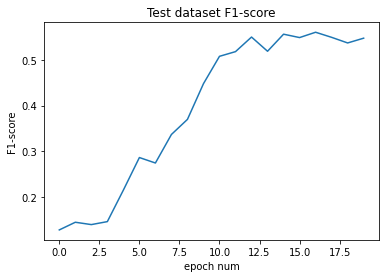

In [94]:
plot_results(list_to_plot=model.test_f1_list, 
             title='Test dataset F1-score', 
             xlab='epoch num', 
             ylab='F1-score')

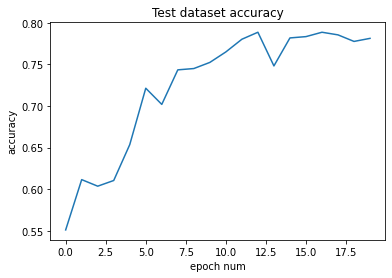

In [95]:
plot_results(list_to_plot=model.test_acc_list, 
             title='Test dataset accuracy', 
             xlab='epoch num', 
             ylab='accuracy')

In [96]:
DISPLAY_EACH_PAIR_FLAG = False

y_pred = model.predict(x_test, batch_size)
preds = list(np.array(y_pred))
reals = y_test
true = 0

for i in range(len(reals)):
    if DISPLAY_EACH_PAIR_FLAG:
        print(f'Pread: {preds[i]} Real: {reals[i]}')
    true = true + 1 if preds[i] == reals[i] else true

print(f'True: {true}\nFalse: {len(reals)-true}')

True: 1486
False: 416


### Confusion matrix

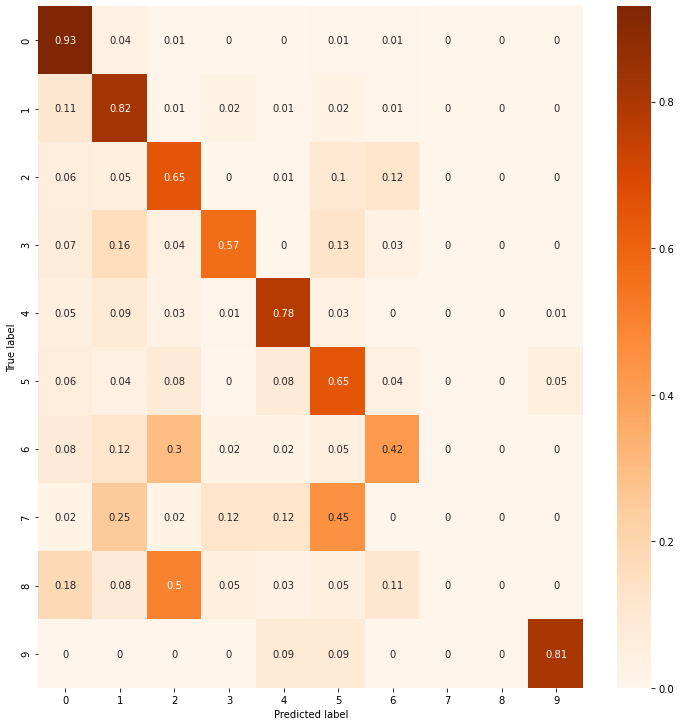

In [97]:
classes = list(range(10))

y_pred = model.predict(x_test, batch_size)

con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = classes, 
                          columns = classes)

figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Oranges)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Podsumowanie
Zaimplementowano warstwę word embedding, która przekształca dodatnie liczby całkowite, reprezentujące indeks słowa w słowniku, na wektory rzeczywiste.


Kolejno zaimplementowano sieci rekurencyjne RNN i LSTM, co było głównym elementem zadania.


Następnie zbadano wpływ następujących parametrów modelu, na efekty uczenia:
- Maksymalna długość wypełnienia wektorów danych:
    - badano następujące wielkości padding max_length: {64, 128}
- Parametryzacja wielkości warstw:
    - badano ustawienia: {10, 30}
- Wymiar embeddingu:
    - badano następujące wielkości: {250, 500}
- Liczba epok uczenia
    - badano następujące ilości epok: {5, 10, 20}
- Model sieci rekurancynej:
    - dwa zadane: {RNN, LSTM}


Korzytsając z informacji zdobytych z poprzednich eksperymentów, zbadano także różne ograniczenia słownika do n najczęściej występujących słów:
- n najczęstszych słów: {250, 500, 1000, 2000}

    
Najleprze wyniki (F1 = 0.54727) otrzymano dla usatwień:
- model = LSTM
- ilość epok = 20
- metoda optymalizacji = Adam
- wartość współczynnika uczenia = 0.0001
- wielkość paczek = 100
- maksymalna długość wypełnienia wektorów = 64
- wielkości warstw = 10
- wymiar embeddingu = 500
- n najczęstszych słów = 2000


Po dokonaniu ewaluacji znalezionej najlepszej konfiguracji hiperparametrów na zbiorze testowym, przedstawiono wizualizacje otrzymanych rezultatów:
- zestawienie wartości metryki F1 w zależności od epoki (dla zbioru treningowego i testowego)
- zestawienie wartości metryki accuracy w zależności od epoki (dla zbioru treningowego i testowego)
- wykresy krzywej funkcji kosztu w zależności od epoki (dla zbioru treningowego i testowego)
- macierz pomyłek


### Wnioski
- Stosowanie zaimplementowanej architektury sieci LSTM daje zwykle znacznie lepsze rezultaty w odniesieniu do RNN, choć nie za każdym razem
- Maksymalna długość wypełnienia wektorów danych ustawiona na wartość 64, w każdym eksperymencie przekłada się na wyższe wyniki i jednocześnie znacząco krótsze czasy uczenia w porównaniu z ustawieniem 128
- Parametr ustawiający wielkość warstw zgodny z ilością klas (10) sprawdził się lepiej niż ustawienie równe wielokrotności ilości klas (3*10)
- Wyższy wymiar embeddingu pozytywnie wpływa na wartości metryk (testowano 250 oraz 500), jednak nieznacznie wydłuża czasy uczenia
- Zwiększenie epok uczenia polepsza wyniki (wpływa oczywiście także na czasy szkoleń)

Embedding:
- https://towardsdatascience.com/how-to-create-word-embedding-in-tensorflow-ed0a61507dd0

RNN:
- https://en.wikipedia.org/wiki/Recurrent_neural_network

LSTM:
- https://en.wikipedia.org/wiki/Long_short-term_memory

Dataset:
- https://keras.io/api/datasets/reuters/

Keras:
- https://keras.io/api/layers/core_layers/embedding/
- https://keras.io/api/layers/recurrent_layers/lstm/